# Import Library

In [1]:
import os
import sys
import itertools
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={"figure.figsize": (25, 10)}, font_scale=1.5)

from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler, RobustScaler

import tensorflow as tf

tf.config.set_visible_devices([], "GPU")
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)
    from models.ts_preprocess import *
    from models.ts_lstm import ForecastLSTM

# Load Dataset

In [2]:
df = pd.read_csv("sample_data.csv")
df["date"] = pd.to_datetime(df["date"])

In [3]:
df

,date,x1,x2,x3,y
0,2016-01-01,4.559453,2.980033,4.055621,4.214337
1,2016-01-02,4.210408,3.029542,3.152499,3.224680
2,2016-01-03,3.370900,3.370900,3.940435,5.128299
3,2016-01-04,3.598311,3.745475,3.153416,2.850409
4,2016-01-05,-8.227478,2.717077,4.155089,4.545156
...,...,...,...,...,...
2187,2021-12-27,3.131693,23.821462,4.663600,21.241504
2188,2021-12-28,3.226848,2.706707,3.980070,3.131693
2189,2021-12-29,3.221490,3.199063,3.596113,3.422970
2190,2021-12-30,3.838340,2.721457,4.174123,3.513204


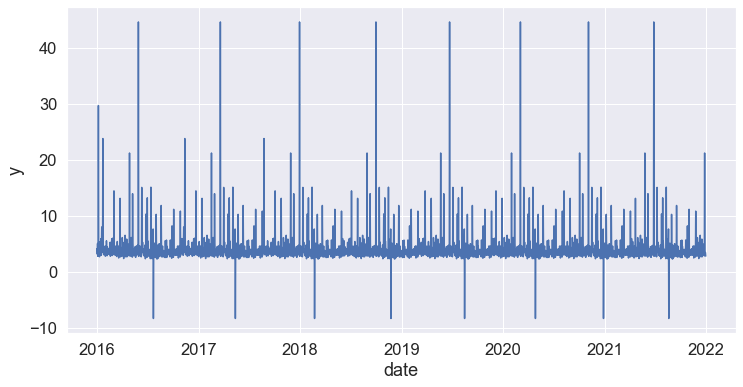

In [4]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x="date", y="y", color="b")
plt.show()

# Functions

In [5]:
def calculate_metrics(df_fcst: pd.DataFrame) -> dict:
    true = df_fcst["y"]
    pred = df_fcst["yhat"]

    mae = (true - pred).abs().mean()
    mape = (true - pred).abs().div(true).mean() * 100
    mse = ((true - pred) ** 2).mean()
    return {
        "mae": mae,
        "mape": mape,
        "mse": mse,
    }

def normalize_dataset(df: pd.DataFrame, scaler: str = "MinMax") -> tuple:
    """
    모델 훈련에 사용할 데이터셋을 정규화한 값과 해당 Scaler를 반환한다.

    :param df: Pandas dataframe to apply feature scaling.
    """

    if "date" in df.columns:
        df = df.set_index("date")

    if "y" not in df.columns:
        raise KeyError("Not found target column 'y'")
    else:
        df = df.drop(columns="y").assign(y=df["y"])

    # Feature Scaler
    if scaler == "MinMax":
        feature_scaler = MinMaxScaler(feature_range=(0, 1))
        target_scaler = MinMaxScaler(feature_range=(0, 1))
    elif scaler == "Robust":
        feature_scaler = RobustScaler()
        target_scaler = RobustScaler()

    features_scaled = pd.DataFrame(
        data=feature_scaler.fit_transform(X=df.iloc[:, :-1]),
        index=df.index,
        columns=df.iloc[:, :-1].columns.values,
    )
    target_scaled = target_scaler.fit_transform(X=df.iloc[:, -1].values.reshape(-1, 1))

    return features_scaled, feature_scaler, target_scaled, target_scaler


def search_hyperparameters(
    params_grid: dict,
    df: pd.DataFrame,
    steps: int,
    single_output: bool,
    metrics: str,
    check_point_path: str = None,
    plot: bool = True,
    target_scaler: object = None,
) -> dict:
    """
    LSTM 모델링을 위해 하이퍼파라미터 조합을 그리드 서치(Grid Search)로 실행한 결과를 반환한다.

    :param params_grid: Hyperparameter spaces.
    :param df: Pandas dataframe for model train.
    :param steps: Time steps to predict.
    :param single_output: Select whether 'y' is a continuous value or a single value.
    :param metrics: Train and validation loss performance metric for model fitting.
    :param check_point_path: Path to save Model.
    :param plot: Plot model traning progress.
    :param target_scaler: Scaler to inverse transform `yhat`.
    """

    # 하이퍼파라미터 grid 생성
    params_grid = [
        dict(zip(params_grid.keys(), v))
        for v in itertools.product(*params_grid.values())
    ]
    num_of_comb = len(params_grid)

    grid_search_result = dict()

    # 파라미터 조합별 모델 훈련
    for params_idx, params in enumerate(params_grid, start=1):
        print(f"parameters ({params_idx}/{num_of_comb}): {params}")

        # 모델 훈련
        fl = ForecastLSTM()
        fl.fit_lstm(
            df=df,
            steps=steps,
            single_output=single_output,
            metrics=metrics,
            check_point_path=f"{check_point_path}_{params_idx}",
            plot=plot,
            **params,
        )

        # 훈련 종료 후 validation dataset 기준 예측값 생성
        df_fcst_val = fl.forecast_validation_dataset()

        # 정규화된 y, yhat을 원래 단위로 변환
        if target_scaler:
            for col in ["y", "yhat"]:
                df_fcst_val[col] = target_scaler.inverse_transform(
                    df_fcst_val[col].values.reshape(-1, 1)
                )

        # Validation dataset의 MAPE 계산
        val_perf_metric = calculate_metrics(df_fcst=df_fcst_val)["mape"]
        print(f"mape of validation dataset: {round(val_perf_metric, 5)}")
        print(
            "--------------------------------------------------------------------------------------------\n"
        )

        # 하이퍼파라미터, 훈련된 모델, 검증 데이터셋의 MAPE 저장
        grid_search_result[params_idx] = (params, fl.model, val_perf_metric)
    return grid_search_result


def get_grid_search_result(grid_search_result: dict) -> pd.DataFrame:
    """
    그리드 서치(Grid Search) 결과로부터 파라미터 조합별 예측 성능을 요약한 결과를 반환한다.

    :param grid_search_result: Result of grid search including parameter, performance metric and model.
    """
    # Grid Search 결과에서 모델별 성능을 pd.DataFrame으로 생성
    df_grid_search_result = pd.DataFrame()
    for k1, v1 in grid_search_result.items():
        params = v1[0].copy()
        score = v1[2]
        for k2, v2 in params.items():
            params[k2] = [params[k2]]
        params["mape"] = score
        df_grid_search_result = pd.concat(
            [df_grid_search_result, pd.DataFrame.from_dict(params)], ignore_index=True
        )
    df_grid_search_result["lstm_units"] = df_grid_search_result["lstm_units"].astype(
        str
    )
    df_grid_search_result["dense_units"] = df_grid_search_result["dense_units"].astype(
        str
    )
    if "steps_per_epoch" in df_grid_search_result.columns:
        df_grid_search_result["steps_per_epoch"] = df_grid_search_result[
            "steps_per_epoch"
        ].astype(str)
    if "batch_size" in df_grid_search_result.columns:
        df_grid_search_result["batch_size"] = df_grid_search_result[
            "batch_size"
        ].astype(str)
    df_grid_search_result = df_grid_search_result.sort_values("mape", ignore_index=True)

    # 각 Hyperparameter에 따라 성능 분포를 확인하고, Hyperparameter 범위를 좁힐지 결정 가능
    for column in df_grid_search_result.columns[:-1]:
        plt.figure(figsize=(8, 4))
        sns.boxplot(data=df_grid_search_result, x=column, y="mape", showmeans=True)
        plt.show()

    return df_grid_search_result


def get_best_model(grid_search_result: dict) -> tuple:
    """
    그리드 서치(Grid Search) 결과로부터 최적의 모델과 해당 하이퍼파라미터를 반환한다.

    :param grid_search_result: Result of grid search including parameter, performance metric and model.
    """
    # Grid Search 결과에서 Best model에 해당하는 인덱스 추출
    model_idx = dict()
    for k, v in grid_search_result.items():
        model_idx[k] = v[2]
    best_model_idx = min(model_idx.keys(), key=model_idx.get)
    print("best model index:", best_model_idx)

    # 해당 모델의 Validation dataset 성능 확인
    validation_loss = grid_search_result[best_model_idx][2].round(4)
    print(f"{metrics} of validation dataset: {validation_loss}")

    # 모델 객체와 파라미터 추출
    model = grid_search_result[best_model_idx][1]
    best_parameter = grid_search_result[best_model_idx][0]
    print("best parameter:", best_parameter)
    return model, best_parameter

# Split Dataset

In [6]:
train_end_dt = "2021-10-31"
test_end_dt = "2021-12-31"

###################
## Train dataset ##
###################
df_train = df.loc[df["date"] < train_end_dt].set_index("date")
df_train_scaled, feature_scaler, target_scaled, target_scaler = normalize_dataset(
    df=df_train, scaler="MinMax"
)
target_scaler_origin = MinMaxScaler(feature_range=(0, 1))
target_scaled_origin = target_scaler_origin.fit_transform(
    X=df_train["y"].values.reshape(-1, 1)
)
df_train_scaled["y"] = target_scaled

##################
## Test dataset ##
##################
df_test = df[df["date"].between(train_end_dt, test_end_dt)].set_index("date")

In [7]:
freq = "D"
n_features = df_train.shape[1] - 1

In [8]:
cutoffs = create_cutoffs(cutoff_start="2021-12-01", cutoff_end=test_end_dt, freq=freq)

# Train model

parameters (1/2): {'seq_len': 8, 'steps_per_epoch': None, 'dropout': 0, 'lstm_units': [64], 'dense_units': [32], 'activation': 'tanh', 'epochs': 500, 'patience': 50, 'learning_rate': 0.01, 'validation_split': 0.3}


2023-02-12 21:41:22.783923: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 8ms/step


1/1 [==============================] - 0s 7ms/step
mape of validation dataset: 2.14776
--------------------------------------------------------------------------------------------

parameters (2/2): {'seq_len': 8, 'steps_per_epoch': None, 'dropout': 0, 'lstm_units': [64], 'dense_units': [32], 'activation': 'linear', 'epochs': 500, 'patience': 50, 'learning_rate': 0.01, 'validation_split': 0.3}


1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - 0s 9ms/step


1/1 [==============================] - 0s 7ms/step


1/1 [==============================] - 0s 11ms/step


1/1 [==============================] - 0s 10ms/step
mape of validation dataset: 21.2212
--------------------------------------------------------------------------------------------



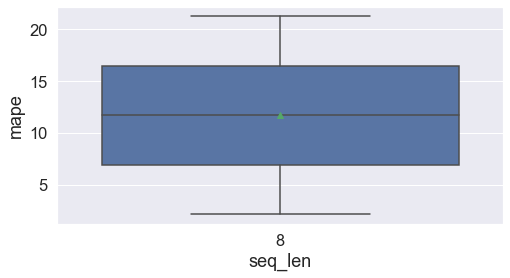

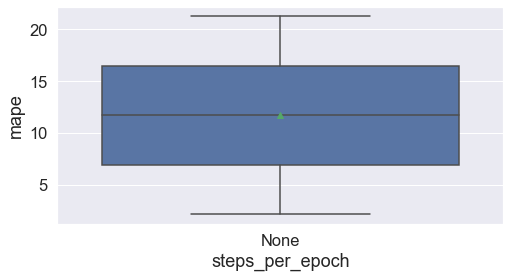

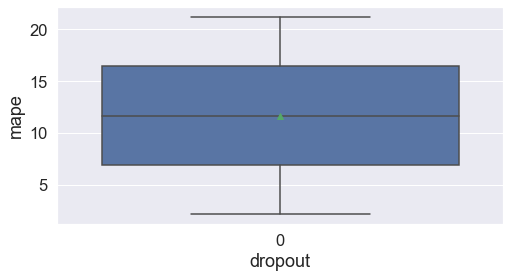

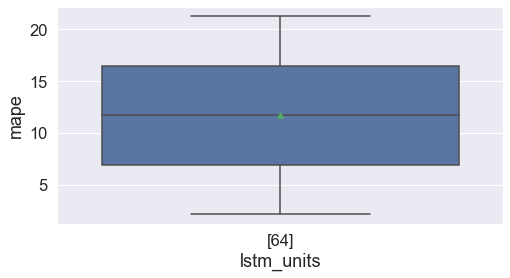

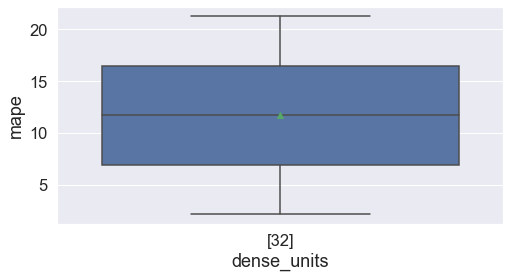

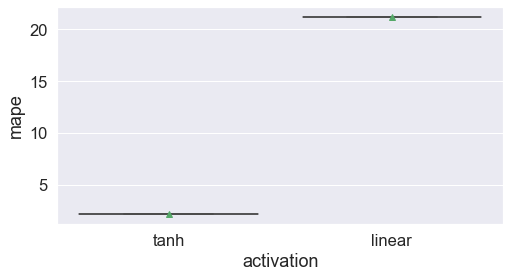

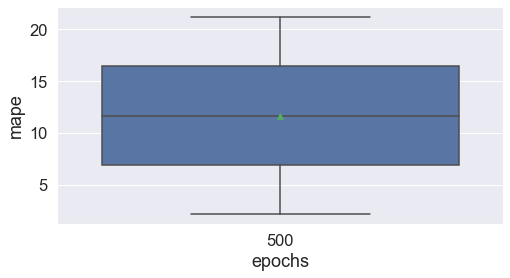

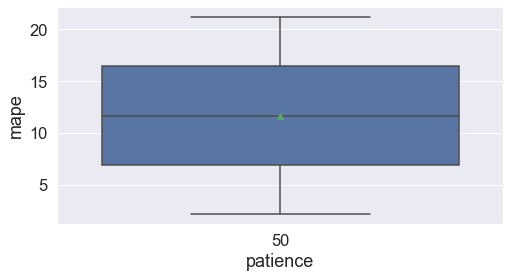

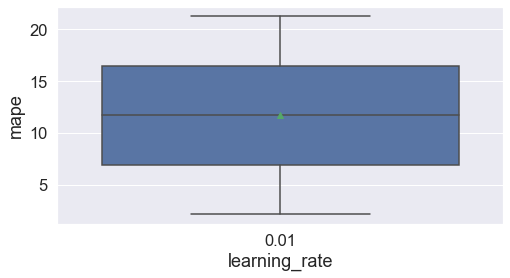

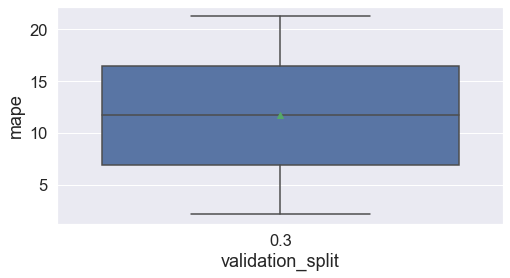

best model index: 1
mse of validation dataset: 2.1478
best parameter: {'seq_len': 8, 'steps_per_epoch': None, 'dropout': 0, 'lstm_units': [64], 'dense_units': [32], 'activation': 'tanh', 'epochs': 500, 'patience': 50, 'learning_rate': 0.01, 'validation_split': 0.3}


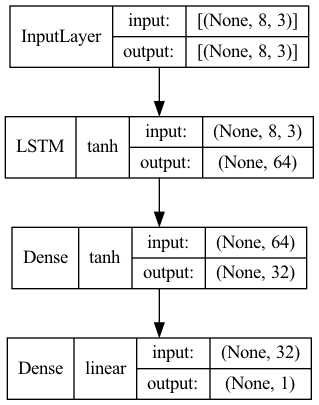

In [9]:
# 예측 기간
steps = 1
single_output = True

# 모델 훈련 metric
metrics = "mse"

# Hyperarameter Space 생성
params_grid = {
    "seq_len": [8],
    "steps_per_epoch": [None],
    "dropout": [0],
    "lstm_units": [[64]],
    "dense_units": [[32]],
    "activation": ["tanh", "linear"],
    "epochs": [500],
    "patience": [50],
    "learning_rate": [0.01],
    "validation_split": [0.3],
}

# Grid Search 실행
grid_search_result = search_hyperparameters(
    df=df_train_scaled,
    steps=steps,
    single_output=single_output,
    metrics=metrics,
    check_point_path="lstm",
    plot=False,
    params_grid=params_grid,
    target_scaler=target_scaler,
)

# 파라미터 조합별 성능 확인
df_grid_search_result = get_grid_search_result(grid_search_result=grid_search_result)

# best model 추출
best_model, best_parameter = get_best_model(grid_search_result=grid_search_result)
tf.keras.utils.plot_model(
    model=best_model,
    show_shapes=True,
    show_layer_names=False,
    show_layer_activations=True,
)

# Forecast test data

In [10]:
def forecast_test_data(
    model,
    df: pd.DataFrame,
    steps: int,
    cutoffs: list,
    freq: str,
    seq_len: int,
    n_features: int,
    single_output: bool,
    feature_scaler: object = None,
    target_scaler: object = None,
) -> pd.DataFrame:
    """
    훈련된 LSTM 모델을 사용하여 Test dataset의 예측 결과를 반환한다.

    :param model: LSTM model.
    :param df: Pandas dataframe for test.
    :param steps: Time steps to predict.
    :param cutoffs: 예측 시작 시점 날짜를 모아 놓은 리스트.
    :param freq: Date frequency of test dataset.
    :param n_features: Number of features (It's for LSTM model shape).
    :param single_output: Select whether 'y' is a continuous value or a single value.
    :param feature_scaler: Scaler to transform features into 0 to 1 (Min-Max).
    :param target_scaler: Scaler to inverse transform `yhat`.
    """

    fl = ForecastLSTM()
    df_fcst = pd.DataFrame()

    # test dataset 추출
    for cutoff in cutoffs:
        X_test, y_test = fl.generate_test_data(
            df=df,
            steps=steps,
            cutoff=cutoff,
            freq=freq,
            seq_len=seq_len,
            single_output=single_output,
        )
        if X_test is None:
            break

        # 훈련 데이터에 사용한 scaler 적용
        X_test_scaled = feature_scaler.transform(X_test)
        y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

        # 예측 값 생성
        x_input = X_test_scaled.reshape(1, seq_len, n_features)
        yhat = model.predict(x_input, use_multiprocessing=True, workers=8)
        df_fcst_tmp = pd.DataFrame(
            {
                "cutoff": cutoff,
                "date": y_test.index,
                "steps": [steps]
                if single_output
                else np.arange(start=1, stop=steps + 1),
                "y": [x[0] for x in y_test_scaled],
                "yhat": yhat[0],
            }
        )
        df_fcst = pd.concat([df_fcst, df_fcst_tmp], ignore_index=True)
    return df_fcst


def get_forecast_error(df_fcst: pd.DataFrame, plot: bool = True) -> tuple:
    """
    Test dataset의 예측 성능을 반환한다.

    :param df_fcst: Pandas dataframe with forecast result of test dataset.
    :param plot: Plot forecast result.
    """
    # # MAPE 계산
    perf_metric = calculate_metrics(df_fcst=df_fcst)["mape"]
    print(f"mape: {round(perf_metric, 2)}%")

    # 예측값과 실제값 시각화
    if plot:
        df_fcst["date"] = df_fcst["date"].astype(str)
        df_fcst["y"] = df_fcst["y"].astype(float)
        df_fcst["yhat"] = df_fcst["yhat"].astype(float)
        plt.figure(figsize=(20, 6))
        sns.lineplot(
            data=df_fcst, x="date", y="y", color="black", marker="o", linewidth=1
        )
        ax = sns.lineplot(data=df_fcst, x="date", y="yhat", marker="o", linewidth=2)
        ax.lines[1].set_linestyle("--")
        plt.xticks(rotation=80)
        plt.legend([f"True", "Forecast", "True (origin)"], loc="best")
        plt.show()
    return perf_metric

1/1 [==============================] - 0s 9ms/step
mape: 6.84%


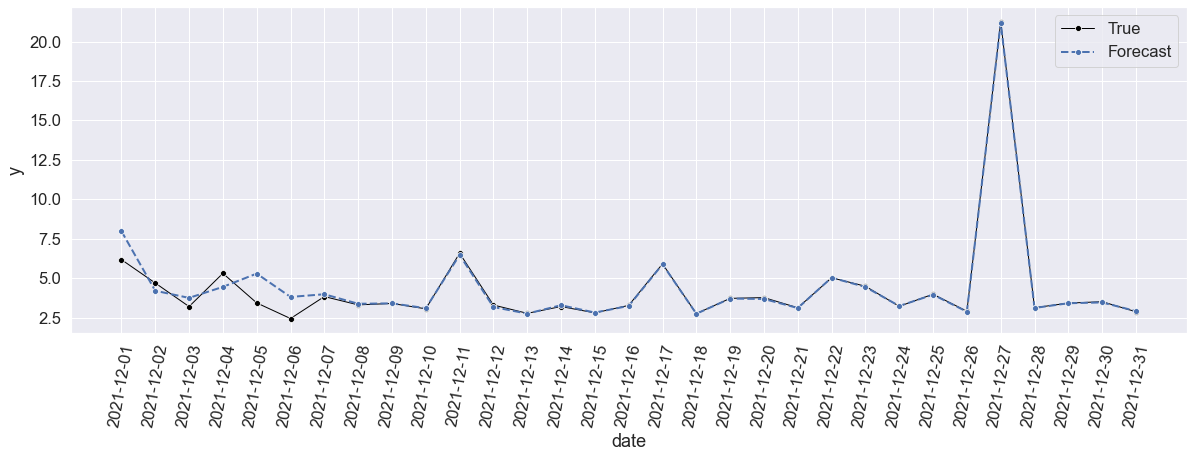

In [11]:
steps = 1

# Test dataset의 주차별 가격 예측
seq_len = best_parameter["seq_len"]

df_fcst = forecast_test_data(
    model=best_model,
    df=df_test,
    steps=steps,
    cutoffs=cutoffs,
    freq=freq,
    n_features=n_features,
    seq_len=seq_len,
    single_output=single_output,
    feature_scaler=feature_scaler,
    target_scaler=target_scaler
)

# 예측값을 원래의 단위로 변경
df_fcst["yhat"] = target_scaler.inverse_transform(df_fcst["yhat"].values.reshape(-1, 1))

# 예측값에 원본 Target 맵핑
df_test_sub = df_test.loc[df_test.index >= df_fcst["date"].min(), "y"].reset_index()
df_fcst_tmp = df_fcst[["cutoff", "date", "steps", "yhat"]]
df_fcst = pd.merge(left=df_test_sub, right=df_fcst_tmp, on="date", how="left")

# 예측 결과
perf_metric = get_forecast_error(df_fcst=df_fcst)
df_fcst["date"] = pd.to_datetime(df_fcst["date"])
df_fcst["year_month"] = df_fcst["date"].dt.strftime("%Y-%m")